**Table of contents**<a id='toc0_'></a>    
- [Sweet Lift Taxi](#toc1_)    
  - [Import Libraries](#toc1_1_)    
  - [EDA](#toc1_2_)    
  - [Model Preparation](#toc1_3_)    
  - [Modeling](#toc1_4_)    
    - [Linear Regression](#toc1_4_1_)    
    - [Decision Tree](#toc1_4_2_)    
    - [Random Forest](#toc1_4_3_)    
    - [Ada Boost](#toc1_4_4_)    
    - [Gradient Boosting](#toc1_4_5_)    
    - [XG boost](#toc1_4_6_)    
    - [Light GBM](#toc1_4_7_)    
    - [Catboost](#toc1_4_8_)    
    - [Voting Regressor](#toc1_4_9_)    
  - [Comparing Model Scores](#toc1_5_)    
  - [Final Model](#toc1_6_)    
    - [Overall Conclusions](#toc1_6_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Sweet Lift Taxi](#toc0_)

Sweet Lift Taxi company has collected data on taxi orders at airports. Their aim is to predict the amount of taxi orders for the next hour, in order to allocate more drivers for peak hours. We will build a model with an RMSE lower than 48. 

****************

In [ ]:
#!pip install --user plotly_express

## <a id='toc1_1_'></a>[Import Libraries](#toc0_)

In [54]:
# Import libraries
import pandas as pd 
import numpy as np
import plotly_express as px 
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, make_scorer
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

In [55]:
# read dataframe
df = pd.read_csv('datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [56]:
# sorting index
df.sort_index(inplace=True)

In [57]:
# checking if index is monotonic
print(df.index.is_monotonic)

True


In [58]:
# look at dataframe
df.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [59]:
# info on num orders columns
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [60]:
# confirming no missing values
df.isna().sum()

num_orders    0
dtype: int64

In [61]:
# resample data by the hour
df = df.resample('1H').sum()

We loaded the data and then converted the dates into datetime format. We then made the datetime column our index, and sorted the index. We checked to make sure the data was free of missing values. Following that, we resampled the data by the hour. 

*************

## <a id='toc1_2_'></a>[EDA](#toc0_)

In [62]:
# summary statistics on the number of orders
df.describe()

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

In [124]:
# hourly number of orders
fig = px.line(df.num_orders, title='Total Hourly Number of Orders', template='ggplot2', height=600, labels={'value': 'Number of Orders'})
fig.update_xaxes(rangeslider_visible=True, 
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='1m', step='month', stepmode='backward'), 
            dict(count=6, label='6m', step='month', stepmode='backward')
            ])
        )
    )
fig.show()

This is a visual of the timeseries data sampled on the hour. The y axis shows the number of taxi orders. 

In [64]:
# distribution of orders
px.box(df.num_orders, title='Distribution of Orders', template='ggplot2', labels={'variable': 'Orders', 'value': 'count'}, height=600)

Here, we have the distribution of the number of orders. We see some outliers with values above 186. The average is 78 orders. 

In [161]:
# Average daily orders
numbers = [6, 12, 24, 168, 720] 
for i in numbers:
    px.line(df.num_orders.rolling(i).mean(), title=f'Mean Number of Orders per {i} Hours', template='ggplot2', labels={'value': 'Number of Orders', 'datetime':'Dates'}, height=600).show()

These visuals show the number of orders resampled for 6 hours, 12 hours, per day, per week, and per month. These visualizations allow us the clearly see the trend in orders increase gradually from April to August. 

In [66]:
# decomposed dataset
decomposed = seasonal_decompose(df)

In [157]:
# decomposed trend 
px.line(decomposed.trend, title='Trend', template='ggplot2')

In [158]:
# decomposed seasonality 
px.line(decomposed.seasonal, title='Seasonality', template='ggplot2')

In [159]:
# decomposed residual 
px.line(decomposed.resid, title='Residual', template='ggplot2')

These visualizations show us the decomposed trends of the data. The trend is the same chart as the resampled daily chart. We see the seasonality chart is tight, which may be due to the short window of time given by the data. The residuals generally fluctuate around 0, but starts to show outliers in August. 

In [160]:
# difference in number of orders
fig = px.line(df.num_orders-df.num_orders.shift(), title='Difference in Number of Orders', template='ggplot2', height=700)
fig.update_xaxes(rangeslider_visible=True, 
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='1m', step='month', stepmode='backward'), 
            dict(count=6, label='6m', step='month', stepmode='backward')
            ])
        )
    )
fig.show()

Looking at the shifted difference in the number of orders, we see the values increase as time increases. These differences become more pronounced from August onward.  

**************

## <a id='toc1_3_'></a>[Model Preparation](#toc0_)

In [71]:
# Making features, max lag 24 and rolling mean 24
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


make_features(df, 24, 24)

In [72]:
# splitting dataset to train, valid, and test
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=19)
train, valid = train_test_split(train, shuffle=False, test_size=0.11, random_state=19)

print('Train Dataset = ', ' Start : ', train.index.min(), '   End : ', train.index.max(), '   Difference : ', abs(train.index.min() - train.index.max()))
print('Valid Dataset = ', ' Start : ', valid.index.min(), '   End : ', valid.index.max(), '   Difference : ', abs(valid.index.min() - valid.index.max()))
print('Test Dataset = ', ' Start : ', test.index.min(),  '   End : ', test.index.max(), '   Difference : ', abs(test.index.min() - test.index.max()))

Train Dataset =   Start :  2018-03-01 00:00:00    End :  2018-07-26 07:00:00    Difference :  147 days 07:00:00
Valid Dataset =   Start :  2018-07-26 08:00:00    End :  2018-08-13 13:00:00    Difference :  18 days 05:00:00
Test Dataset =   Start :  2018-08-13 14:00:00    End :  2018-08-31 23:00:00    Difference :  18 days 09:00:00


In [73]:
# Dropping missing values from datasets 
train = train.dropna()
valid = valid.dropna() 
test = test.dropna()

In [74]:
# Splitting target and features
X_train = train.drop(columns='num_orders')
y_train = train.num_orders

X_valid = valid.drop(columns='num_orders')
y_valid = valid.num_orders 

X_test = test.drop(columns='num_orders')
y_test = test.num_orders

In [75]:
features = df.drop(columns='num_orders')
target = df.num_orders

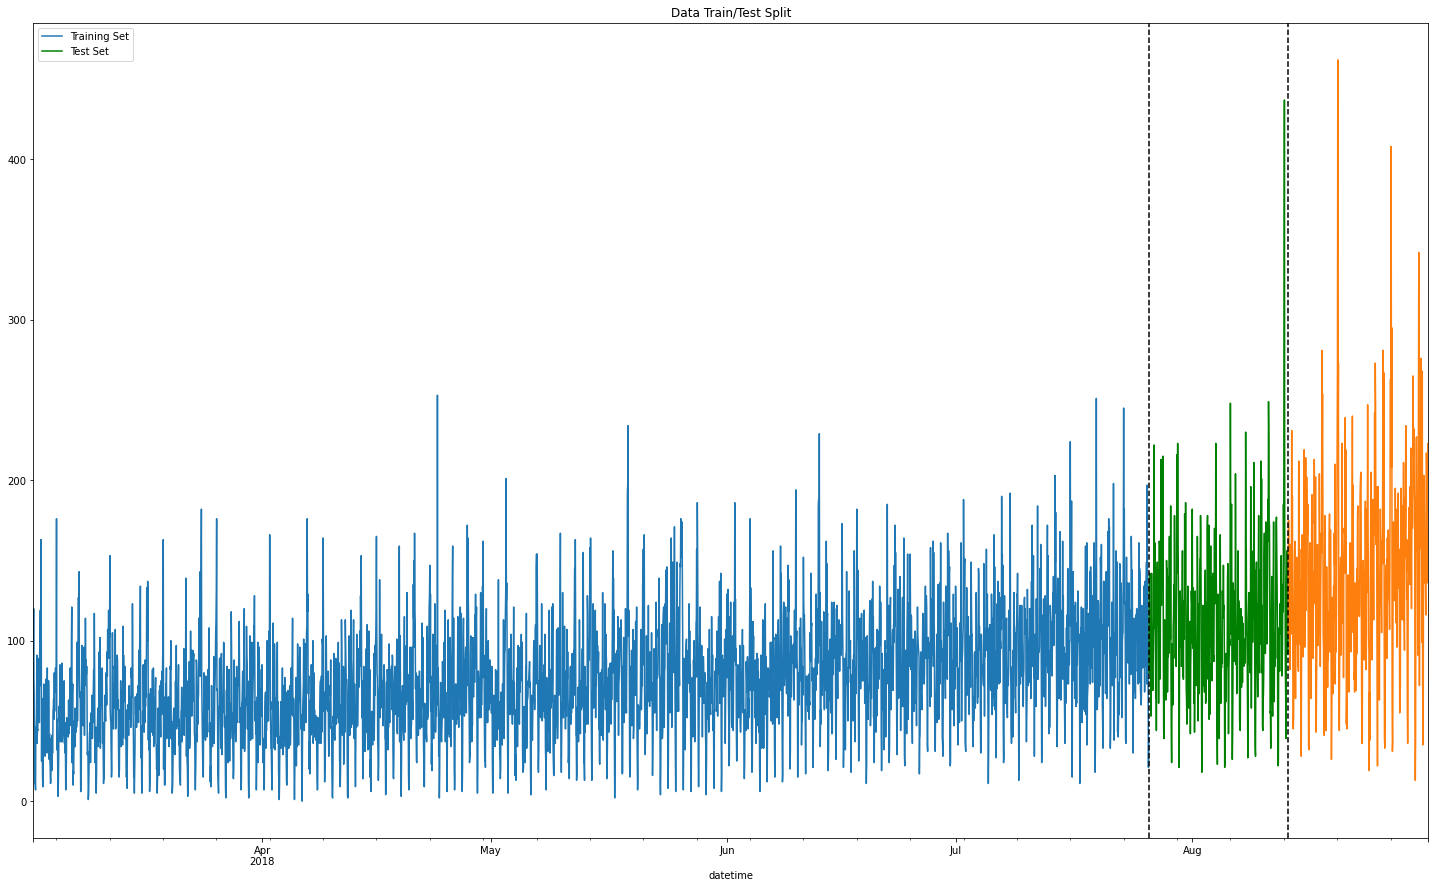

In [76]:
# visual of train test split
fig, ax = plt.subplots(figsize=(25,15))
train.num_orders.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
valid.num_orders.plot(ax=ax, label='Valid Set', color='green')
test.num_orders.plot(ax=ax, label='Test Set')
ax.axvline('2018-07-26 08:00:00', color='black', ls='--')
ax.axvline('2018-08-13 14:00:00', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


We define a function to make features, with a max lag of 24 and a rolling mean of 24. We then split the data into three parts: train, valid, and test. We will train the models with the training data, then tune the models with the validation set. The test set is reserved for evaluating the performance of the final model we choose. Since it is crucial to have adequate training data, we limited the validation and test sets to 10% of the data each. This leaves roughly 80% of the data for training. Furthermore, with time series, we can not randomly select points in our data to split, so shuffle was set to false. This gives us the correct sequence in the order of the different sets, made evident by the last figure. 

**************

## <a id='toc1_4_'></a>[Modeling](#toc0_)

### <a id='toc1_4_1_'></a>[Linear Regression](#toc0_)

In [77]:
# linear regression
lr = LinearRegression() # initialize model constructor
lr.fit(X_train, y_train) # train model on training set

predictions_valid_lr = lr.predict(X_valid) # get model predictions on validation set

result = mse(y_valid, predictions_valid_lr) ** 0.5 # calculate RMSE on validation set
print("RMSE of the linear regression model on the validation set:", result)


RMSE of the linear regression model on the validation set: 34.282142440117


In [78]:
# Get the feature importances of the best model
lr_importances = lr.coef_

# Create a dataframe with the feature importances and the corresponding feature names
lr_importances_df = pd.DataFrame({'feature':X_train.columns, 'coefficients':lr.coef_})

# Sort the dataframe by importance
lr_importances_df.sort_values(by='coefficients', ascending=False, inplace=True)

feature  coefficients
29  rolling_mean  3.443462e+12
1          month  3.741096e+00
4           hour  6.812351e-01
2            day  1.919355e-01
0           year -1.203887e-15
3      dayofweek -2.726262e-01
28        lag_24 -1.434776e+11
5          lag_1 -1.434776e+11
12         lag_8 -1.434776e+11
6          lag_2 -1.434776e+11
27        lag_23 -1.434776e+11
11         lag_7 -1.434776e+11
15        lag_11 -1.434776e+11
20        lag_16 -1.434776e+11
17        lag_13 -1.434776e+11
26        lag_22 -1.434776e+11
9          lag_5 -1.434776e+11
16        lag_12 -1.434776e+11
21        lag_17 -1.434776e+11
7          lag_3 -1.434776e+11
8          lag_4 -1.434776e+11
14        lag_10 -1.434776e+11
10         lag_6 -1.434776e+11
25        lag_21 -1.434776e+11
18        lag_14 -1.434776e+11
19        lag_15 -1.434776e+11
22        lag_18 -1.434776e+11
23        lag_19 -1.434776e+11
24        lag_20 -1.434776e+11
13         lag_9 -1.434776e+11

The rolling mean is the coefficient with the highest value among the linear regression features. We achieve an RMSE score of 34.28 with the validation set. 

### <a id='toc1_4_2_'></a>[Decision Tree](#toc0_)

In [79]:
# Decision Tree
best_model = None
best_result = 50
best_depth = 0
for depth in range(1, 6): # choose hyperparameter range
    dtr = DecisionTreeRegressor(random_state=19, max_depth=depth)
    dtr.fit(X_train, y_train) # train model on training set
    predictions_valid_dtr = dtr.predict(X_valid) # get model predictions on validation set
    result = mse(y_valid, predictions_valid_dtr) ** 0.5
    if result < best_result:
        best_model = dtr
        best_result = result
        best_depth = depth

print(f"RMSE of the best model on the validation set (max_depth = {best_depth}): {best_result}")

RMSE of the best model on the validation set (max_depth = 5): 38.54337041017864


In [80]:
# Get the feature importances of the best model
dtr_importances = dtr.feature_importances_

# Create a dataframe with the feature importances and the corresponding feature names
dtr_importances_df = pd.DataFrame({'feature':X_train.columns, 'importance':dtr.feature_importances_})

# Sort the dataframe by importance
dtr_importances_df.sort_values(by='importance', ascending=False, inplace=True)

In [81]:
# top 10 feature importances
px.pie(dtr_importances_df.head(10), names='feature', values='importance', title='Top 10 Feature Importance for Decision Tree Regression', template='ggplot2', hole=0.2)

The lag 24 feature is the most important in the decesion tree regression. We achieve an RMSE score of 38.54 with the validation set. 

### <a id='toc1_4_3_'></a>[Random Forest](#toc0_)

In [82]:
# Random Forest 
best_model = None
best_result = 50
best_est = 0
best_depth = 0
for est in range(600, 601):
    for depth in range (100, 101):
        rf = RandomForestRegressor(random_state=19, n_estimators=est, max_depth=depth)
        rf.fit(X_train, y_train) # train model on training set
        predictions_valid = rf.predict(X_valid) # get model predictions on validation set
        result = mse(y_valid, predictions_valid) ** 0.5 # calculate RMSE on validation set
        if result < best_result:
            best_model = rf
            best_result = result
            best_est = est
            best_depth = depth
            
print("RMSE of the best model on the validation set:", best_result, "n_estimators:", best_est, "best_depth:", depth)

RMSE of the best model on the validation set: 32.013650992753774 n_estimators: 600 best_depth: 100


In [83]:
# Get the feature importances of the best model
rf_importances = best_model.feature_importances_

# Create a dataframe with the feature importances and the corresponding feature names
rf_importances_df = pd.DataFrame({'feature':X_train.columns, 'importance':rf.feature_importances_})

# Sort the dataframe by importance
rf_importances_df.sort_values(by='importance', ascending=False, inplace=True)

In [84]:
# top 10 feature importances
px.pie(rf_importances_df.head(10), names='feature', values='importance', title='Top 10 Feature Importance for Random Forest Regression', template='ggplot2', hole=0.2)

The Lag 24 feature has the greatest importance in the random forest model. The RMSE score is 32.01. 

### <a id='toc1_4_4_'></a>[Ada Boost](#toc0_)

In [85]:
# ADA Boost
regr = AdaBoostRegressor(random_state=19, n_estimators=100)
regr.fit(X_train, y_train)  

predictions_valid_regr = regr.predict(X_valid) # get model predictions on validation set

result = mse(y_valid, predictions_valid_regr) ** 0.5 # calculate RMSE on validation set
print("RMSE of the ada boost regression model on the validation set:", result)

RMSE of the ada boost regression model on the validation set: 34.89293536381952


In [86]:
# table of feature importance
regr_imp = [t for t in zip(features, regr.feature_importances_)]
regr_imp_df = pd.DataFrame(regr_imp, columns=['feature', 'varimp'])
regr_imp_df = regr_imp_df.sort_values('varimp', ascending=False)


In [87]:
# top 10 feature importances
px.pie(regr_imp_df.head(10), names='feature', values='varimp', title='Top 10 Feature Importance for Ada Boost Regresion', hole=.2, template='ggplot2')

The lag 24 feature is the most important, followed by the lag 1, among the Ada Boost model. The RMSE score is 34.89.

### <a id='toc1_4_5_'></a>[Gradient Boosting](#toc0_)

In [139]:
# Gradient Boost
gbr = GradientBoostingRegressor(random_state=19, learning_rate=0.2, n_estimators=1000, verbose=1, max_depth=3)
gbr.fit(X_train, y_train)

predictions_valid_gbr = gbr.predict(X_valid)

result = mse(y_valid, predictions_valid_gbr) ** 0.5 # calculate RMSE on validation set
print("RMSE of the gradient boosting model on the validation set:", result)

      Iter       Train Loss   Remaining Time 
         1        1055.7262           12.97s
         2         902.6644           12.95s
         3         800.7340           12.60s
         4         723.8976           12.17s
         5         664.3207           12.11s
         6         624.8460           10.34s
         7         593.0704           11.08s
         8         561.8075           11.62s
         9         540.4896           10.32s
        10         523.9846           10.82s
        20         433.9193           11.69s
        30         394.4030           11.05s
        40         367.8561           11.23s
        50         347.6763           10.76s
        60         327.1108           10.92s
        70         313.1352           10.75s
        80         299.1902           10.64s
        90         284.5592           10.63s
       100         273.5208           10.51s
       200         186.1205            9.35s
       300         136.8925            8.21s
       40

In [89]:
# table of feature importance
gbr_imp = [t for t in zip(features, gbr.feature_importances_)]
gbr_imp_df = pd.DataFrame(gbr_imp, columns=['feature', 'varimp'])
gbr_imp_df = gbr_imp_df.sort_values('varimp', ascending=False)

In [90]:
# top 10 feature importances
px.pie(gbr_imp_df.head(10), names='feature', values='varimp', title='Top 10 Feature Importance for Gradient Boosting', hole=.2, template='ggplot2')

The lag 24 feature is the most important, followed by the lag 1, among the Gradient Boost model. The RMSE score is 35.12.

### <a id='toc1_4_6_'></a>[XG boost](#toc0_)

In [136]:
# XGB 
xgbr = XGBRegressor(learning_rate=0.09, n_estimators=800, eval_metric='rmse', random_state=19, max_depth=6, early_stopping_rounds=500)

xgbr.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=200)

# Make predictions on the test set
predictions_xgbr = xgbr.predict(X_valid)

result = mse(y_valid, predictions_xgbr) ** 0.5 # calculate RMSE on validation set
print()
print("RMSE of the xgbm model on the validation set:", result)

[0]	validation_0-rmse:75.35697	validation_1-rmse:110.75678
[200]	validation_0-rmse:7.92080	validation_1-rmse:31.72392
[400]	validation_0-rmse:4.38308	validation_1-rmse:31.72114
[600]	validation_0-rmse:2.29920	validation_1-rmse:31.73506
[658]	validation_0-rmse:1.90277	validation_1-rmse:31.74793

RMSE of the xgbm model on the validation set: 31.691194462756986


In [92]:
# table of feature importance
xgbr_imp = [t for t in zip(features, xgbr.feature_importances_)]
xgbr_imp_df = pd.DataFrame(xgbr_imp, columns=['feature', 'varimp'])
xgbr_imp_df = xgbr_imp_df.sort_values('varimp', ascending=False)

In [93]:
# top 10 feature importances
px.pie(xgbr_imp_df.head(10), names='feature', values='varimp', title='Top 10 Feature Importance for XG Boost', hole=.2, template='ggplot2')

The lag 24 feature is the most important, followed by the lag 1, among the XG Boost model. The RMSE score is 31.69.

### <a id='toc1_4_7_'></a>[Light GBM](#toc0_)

In [164]:
# LGBM

# Create a LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train, params={'verbose': -1}, free_raw_data=False)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train, params={'verbose': -1}, free_raw_data=False)

# Define the parameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'root_mean_squared_error',
    'boosting_type': 'gbdt',
    'random_state': 19,
    'verbose': -1
}

# Train the LightGBM model
lgbm = lgb.train(params, lgb_train, valid_sets=lgb_valid, num_boost_round=100, early_stopping_rounds=50, verbose_eval=False)

# Make predictions on the test set
predictions_valid_lgbm = lgbm.predict(X_valid)

result = mse(y_valid, predictions_valid_lgbm) ** 0.5 # calculate RMSE on validation set
print()
print("RMSE of the lgbm model on the validation set:", result)

C:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\XIX\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.




RMSE of the lgbm model on the validation set: 31.5105670958812


In [95]:
# Get the feature importances of the trained model
lgbm_importances = lgbm.feature_importance()

# Create a dataframe with the feature importances and the corresponding feature names
lgbm_importances_df = pd.DataFrame({'feature':X_train.columns, 'importance':lgbm_importances})

# Sort the dataframe by importance
lgbm_importances_df.sort_values(by='importance', ascending=False, inplace=True)


In [96]:
# top 10 feature importances
px.pie(lgbm_importances_df.head(10), names='feature', values='importance', title='Top 10 Feature Importance for Light GBM Regression', hole=.2, template='ggplot2')

The lag 24 feature is the most important, followed by the lag 1, 3, and 17,  among the light GB model. The RMSE score is 31.51.

### <a id='toc1_4_8_'></a>[Catboost](#toc0_)

In [123]:
# catboost

catb = CatBoostRegressor(task_type='GPU', loss_function='RMSE', eval_metric='RMSE', iterations=2000, random_seed=19, early_stopping_rounds=500)

catb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=100, use_best_model=True)

# Make predictions on the test set
predictions_valid_catb = catb.predict(X_valid)

result = mse(y_valid, predictions_valid_catb) ** 0.5 # calculate RMSE on validation set
print()
print("Catboost model on the test set: ")
catb.best_score_

Learning rate set to 0.058377
0:	learn: 34.6860472	test: 56.9806604	best: 56.9806604 (0)	total: 35.5ms	remaining: 1m 10s
100:	learn: 19.2988741	test: 33.0876620	best: 33.0876620 (100)	total: 3.39s	remaining: 1m 3s
200:	learn: 17.3837171	test: 31.5593320	best: 31.5274555 (196)	total: 5.9s	remaining: 52.8s
300:	learn: 16.1068747	test: 31.1158582	best: 31.0932530 (292)	total: 8.34s	remaining: 47.1s
400:	learn: 15.1570285	test: 30.9089598	best: 30.8874333 (355)	total: 11.5s	remaining: 45.7s
500:	learn: 14.4524653	test: 30.6655332	best: 30.6543250 (489)	total: 14.5s	remaining: 43.4s
600:	learn: 13.8817461	test: 30.6080922	best: 30.5862454 (598)	total: 17.2s	remaining: 40s
700:	learn: 13.4356620	test: 30.7307059	best: 30.5862454 (598)	total: 20.1s	remaining: 37.2s
800:	learn: 12.9640404	test: 30.6683495	best: 30.5862454 (598)	total: 22.5s	remaining: 33.7s
900:	learn: 12.4940995	test: 30.5313766	best: 30.5306439 (899)	total: 25.2s	remaining: 30.7s
1000:	learn: 12.2133156	test: 30.4880769	best

{'learn': {'RMSE': 10.689158761762712},
 'validation': {'RMSE': 30.420446065315765}}

In [98]:
# Get the feature importances of the trained model
catb_importances = catb.feature_importances_

# Create a dataframe with the feature importances and the corresponding feature names
catb_importances_df = pd.DataFrame({'feature':X_train.columns, 'importance':catb_importances})

# Sort the dataframe by importance
catb_importances_df.sort_values(by='importance', ascending=False, inplace=True)

In [99]:
# top 10 feature importances
px.pie(catb_importances_df.head(10), names='feature', values='importance', title='Top 10 Feature Importance for Catboost Regression', hole=.2, template='ggplot2')

The lag 24 feature is the most important, followed by the lag 1, among the catboost model. The RMSE score is 30.42.

### <a id='toc1_4_9_'></a>[Voting Regressor](#toc0_)

In [153]:
# Training classifiers
# reg1 = RandomForestRegressor(random_state=12345, n_estimators=90, max_depth=100)
# reg2 = GradientBoostingRegressor(random_state=19, learning_rate=0.2, n_estimators=1000, verbose=1, max_depth=3)
reg3 = XGBRegressor(learning_rate=0.09, n_estimators=800, eval_metric='rmse', random_state=19, max_depth=6) #, early_stopping_rounds=500)
reg4 = lgb.LGBMRegressor(objective='regression', metric='root_mean_squared_error', boosting_type='gbdt', random_state=19) #, early_stopping_rounds=50)
reg5 = CatBoostRegressor(task_type='GPU', loss_function='RMSE', eval_metric='RMSE', iterations=2000, random_seed=19) #, early_stopping_rounds=500)

ereg = VotingRegressor(estimators=[#('rf', reg1), 
                                #('gbr', reg2), 
                                ('xgb', reg3), 
                                ('lgb', reg4), 
                                ('cat', reg5)]
                                
                               )
ereg = ereg.fit(X_train, y_train)

# Make predictions on the test set
predictions_valid_ereg = ereg.predict(X_valid)

result = mse(y_valid, predictions_valid_ereg) ** 0.5 # calculate RMSE on validation set
print()
print("voting regressor model on the valid set: ", result)

Learning rate set to 0.031482
0:	learn: 35.1676509	total: 26.2ms	remaining: 52.3s
1:	learn: 34.6376048	total: 51.1ms	remaining: 51s
2:	learn: 34.1313414	total: 74.8ms	remaining: 49.8s
3:	learn: 33.6339046	total: 98.7ms	remaining: 49.2s
4:	learn: 33.1358757	total: 122ms	remaining: 48.6s
5:	learn: 32.6747525	total: 146ms	remaining: 48.4s
6:	learn: 32.2358715	total: 169ms	remaining: 48s
7:	learn: 31.8023296	total: 194ms	remaining: 48.2s
8:	learn: 31.3844726	total: 226ms	remaining: 50.1s
9:	learn: 31.0054532	total: 250ms	remaining: 49.7s
10:	learn: 30.6055730	total: 275ms	remaining: 49.8s
11:	learn: 30.2338397	total: 300ms	remaining: 49.7s
12:	learn: 29.8893187	total: 323ms	remaining: 49.4s
13:	learn: 29.5460904	total: 347ms	remaining: 49.2s
14:	learn: 29.2083536	total: 370ms	remaining: 49s
15:	learn: 28.9176478	total: 393ms	remaining: 48.8s
16:	learn: 28.6135442	total: 425ms	remaining: 49.6s
17:	learn: 28.3471001	total: 451ms	remaining: 49.6s
18:	learn: 28.0779035	total: 475ms	remaining: 

157:	learn: 19.7984254	total: 3.98s	remaining: 46.5s
158:	learn: 19.7781654	total: 4.01s	remaining: 46.5s
159:	learn: 19.7580764	total: 4.04s	remaining: 46.5s
160:	learn: 19.7494359	total: 4.07s	remaining: 46.4s
161:	learn: 19.7280873	total: 4.09s	remaining: 46.4s
162:	learn: 19.7146085	total: 4.11s	remaining: 46.4s
163:	learn: 19.6914139	total: 4.14s	remaining: 46.3s
164:	learn: 19.6680507	total: 4.16s	remaining: 46.3s
165:	learn: 19.6506052	total: 4.19s	remaining: 46.3s
166:	learn: 19.6362331	total: 4.22s	remaining: 46.3s
167:	learn: 19.6281990	total: 4.24s	remaining: 46.3s
168:	learn: 19.6184381	total: 4.26s	remaining: 46.2s
169:	learn: 19.6104258	total: 4.29s	remaining: 46.2s
170:	learn: 19.5916501	total: 4.31s	remaining: 46.1s
171:	learn: 19.5764738	total: 4.33s	remaining: 46.1s
172:	learn: 19.5649199	total: 4.36s	remaining: 46s
173:	learn: 19.5514014	total: 4.38s	remaining: 45.9s
174:	learn: 19.5309617	total: 4.4s	remaining: 45.9s
175:	learn: 19.5130589	total: 4.43s	remaining: 46

319:	learn: 17.9131967	total: 7.98s	remaining: 41.9s
320:	learn: 17.9017851	total: 8.02s	remaining: 41.9s
321:	learn: 17.8868456	total: 8.04s	remaining: 41.9s
322:	learn: 17.8826783	total: 8.06s	remaining: 41.9s
323:	learn: 17.8720618	total: 8.09s	remaining: 41.8s
324:	learn: 17.8569050	total: 8.11s	remaining: 41.8s
325:	learn: 17.8483252	total: 8.13s	remaining: 41.8s
326:	learn: 17.8324308	total: 8.16s	remaining: 41.8s
327:	learn: 17.8173971	total: 8.19s	remaining: 41.8s
328:	learn: 17.8119008	total: 8.22s	remaining: 41.8s
329:	learn: 17.8023087	total: 8.25s	remaining: 41.7s
330:	learn: 17.7907060	total: 8.27s	remaining: 41.7s
331:	learn: 17.7811515	total: 8.29s	remaining: 41.7s
332:	learn: 17.7755919	total: 8.32s	remaining: 41.6s
333:	learn: 17.7685584	total: 8.34s	remaining: 41.6s
334:	learn: 17.7550965	total: 8.36s	remaining: 41.6s
335:	learn: 17.7511359	total: 8.38s	remaining: 41.5s
336:	learn: 17.7377239	total: 8.41s	remaining: 41.5s
337:	learn: 17.7258058	total: 8.44s	remaining:

476:	learn: 16.6900856	total: 12s	remaining: 38.3s
477:	learn: 16.6792285	total: 12s	remaining: 38.3s
478:	learn: 16.6744217	total: 12s	remaining: 38.3s
479:	learn: 16.6727007	total: 12.1s	remaining: 38.2s
480:	learn: 16.6713616	total: 12.1s	remaining: 38.2s
481:	learn: 16.6641429	total: 12.1s	remaining: 38.2s
482:	learn: 16.6578120	total: 12.1s	remaining: 38.1s
483:	learn: 16.6463310	total: 12.2s	remaining: 38.1s
484:	learn: 16.6336988	total: 12.2s	remaining: 38.1s
485:	learn: 16.6259623	total: 12.2s	remaining: 38.1s
486:	learn: 16.6239108	total: 12.3s	remaining: 38.1s
487:	learn: 16.6172284	total: 12.3s	remaining: 38.1s
488:	learn: 16.6101710	total: 12.3s	remaining: 38s
489:	learn: 16.6080698	total: 12.3s	remaining: 38s
490:	learn: 16.5996904	total: 12.4s	remaining: 38s
491:	learn: 16.5996894	total: 12.4s	remaining: 37.9s
492:	learn: 16.5897917	total: 12.4s	remaining: 37.9s
493:	learn: 16.5809695	total: 12.4s	remaining: 37.9s
494:	learn: 16.5763972	total: 12.5s	remaining: 37.9s
495:	

640:	learn: 15.6837920	total: 16.3s	remaining: 34.6s
641:	learn: 15.6803848	total: 16.3s	remaining: 34.6s
642:	learn: 15.6720715	total: 16.4s	remaining: 34.5s
643:	learn: 15.6672265	total: 16.4s	remaining: 34.5s
644:	learn: 15.6598188	total: 16.4s	remaining: 34.5s
645:	learn: 15.6528266	total: 16.4s	remaining: 34.4s
646:	learn: 15.6464960	total: 16.5s	remaining: 34.4s
647:	learn: 15.6448496	total: 16.5s	remaining: 34.4s
648:	learn: 15.6434936	total: 16.5s	remaining: 34.4s
649:	learn: 15.6336462	total: 16.5s	remaining: 34.4s
650:	learn: 15.6310694	total: 16.6s	remaining: 34.3s
651:	learn: 15.6225790	total: 16.6s	remaining: 34.3s
652:	learn: 15.6186251	total: 16.6s	remaining: 34.3s
653:	learn: 15.6163775	total: 16.6s	remaining: 34.2s
654:	learn: 15.6150139	total: 16.7s	remaining: 34.2s
655:	learn: 15.6114520	total: 16.7s	remaining: 34.2s
656:	learn: 15.6107503	total: 16.7s	remaining: 34.2s
657:	learn: 15.6079628	total: 16.7s	remaining: 34.1s
658:	learn: 15.6003952	total: 16.8s	remaining:

799:	learn: 14.9738543	total: 20.1s	remaining: 30.2s
800:	learn: 14.9653287	total: 20.1s	remaining: 30.1s
801:	learn: 14.9561735	total: 20.2s	remaining: 30.1s
802:	learn: 14.9463871	total: 20.2s	remaining: 30.1s
803:	learn: 14.9456048	total: 20.2s	remaining: 30.1s
804:	learn: 14.9354570	total: 20.2s	remaining: 30s
805:	learn: 14.9354552	total: 20.2s	remaining: 30s
806:	learn: 14.9284884	total: 20.3s	remaining: 30s
807:	learn: 14.9212119	total: 20.3s	remaining: 29.9s
808:	learn: 14.9117856	total: 20.3s	remaining: 29.9s
809:	learn: 14.9067175	total: 20.3s	remaining: 29.9s
810:	learn: 14.9013544	total: 20.4s	remaining: 29.9s
811:	learn: 14.9013532	total: 20.4s	remaining: 29.8s
812:	learn: 14.8998460	total: 20.4s	remaining: 29.8s
813:	learn: 14.8967874	total: 20.4s	remaining: 29.8s
814:	learn: 14.8927485	total: 20.5s	remaining: 29.7s
815:	learn: 14.8922298	total: 20.5s	remaining: 29.7s
816:	learn: 14.8853630	total: 20.5s	remaining: 29.7s
817:	learn: 14.8781467	total: 20.5s	remaining: 29.7s

955:	learn: 14.3869070	total: 23.7s	remaining: 25.8s
956:	learn: 14.3839634	total: 23.7s	remaining: 25.8s
957:	learn: 14.3839547	total: 23.7s	remaining: 25.8s
958:	learn: 14.3829469	total: 23.7s	remaining: 25.7s
959:	learn: 14.3817727	total: 23.7s	remaining: 25.7s
960:	learn: 14.3774349	total: 23.8s	remaining: 25.7s
961:	learn: 14.3769355	total: 23.8s	remaining: 25.7s
962:	learn: 14.3744082	total: 23.8s	remaining: 25.6s
963:	learn: 14.3724755	total: 23.8s	remaining: 25.6s
964:	learn: 14.3631017	total: 23.9s	remaining: 25.6s
965:	learn: 14.3566883	total: 23.9s	remaining: 25.6s
966:	learn: 14.3463993	total: 23.9s	remaining: 25.6s
967:	learn: 14.3397948	total: 23.9s	remaining: 25.5s
968:	learn: 14.3387325	total: 24s	remaining: 25.5s
969:	learn: 14.3381566	total: 24s	remaining: 25.5s
970:	learn: 14.3380914	total: 24s	remaining: 25.4s
971:	learn: 14.3360750	total: 24s	remaining: 25.4s
972:	learn: 14.3295067	total: 24.1s	remaining: 25.4s
973:	learn: 14.3294955	total: 24.1s	remaining: 25.4s
9

1110:	learn: 13.8881046	total: 27.2s	remaining: 21.8s
1111:	learn: 13.8840535	total: 27.3s	remaining: 21.8s
1112:	learn: 13.8810122	total: 27.3s	remaining: 21.7s
1113:	learn: 13.8772482	total: 27.3s	remaining: 21.7s
1114:	learn: 13.8719407	total: 27.3s	remaining: 21.7s
1115:	learn: 13.8687382	total: 27.3s	remaining: 21.7s
1116:	learn: 13.8671784	total: 27.4s	remaining: 21.6s
1117:	learn: 13.8602319	total: 27.4s	remaining: 21.6s
1118:	learn: 13.8561496	total: 27.4s	remaining: 21.6s
1119:	learn: 13.8561104	total: 27.4s	remaining: 21.6s
1120:	learn: 13.8493563	total: 27.5s	remaining: 21.5s
1121:	learn: 13.8469313	total: 27.5s	remaining: 21.5s
1122:	learn: 13.8428296	total: 27.5s	remaining: 21.5s
1123:	learn: 13.8356471	total: 27.5s	remaining: 21.5s
1124:	learn: 13.8356362	total: 27.6s	remaining: 21.4s
1125:	learn: 13.8329921	total: 27.6s	remaining: 21.4s
1126:	learn: 13.8307502	total: 27.6s	remaining: 21.4s
1127:	learn: 13.8307328	total: 27.6s	remaining: 21.3s
1128:	learn: 13.8269152	tota

1265:	learn: 13.4212896	total: 31s	remaining: 18s
1266:	learn: 13.4201486	total: 31s	remaining: 17.9s
1267:	learn: 13.4173085	total: 31s	remaining: 17.9s
1268:	learn: 13.4134761	total: 31s	remaining: 17.9s
1269:	learn: 13.4084561	total: 31.1s	remaining: 17.9s
1270:	learn: 13.4084535	total: 31.1s	remaining: 17.8s
1271:	learn: 13.4028281	total: 31.1s	remaining: 17.8s
1272:	learn: 13.3978799	total: 31.1s	remaining: 17.8s
1273:	learn: 13.3918568	total: 31.2s	remaining: 17.8s
1274:	learn: 13.3872674	total: 31.2s	remaining: 17.7s
1275:	learn: 13.3857492	total: 31.2s	remaining: 17.7s
1276:	learn: 13.3854201	total: 31.2s	remaining: 17.7s
1277:	learn: 13.3815354	total: 31.3s	remaining: 17.7s
1278:	learn: 13.3739754	total: 31.3s	remaining: 17.6s
1279:	learn: 13.3707602	total: 31.3s	remaining: 17.6s
1280:	learn: 13.3630863	total: 31.4s	remaining: 17.6s
1281:	learn: 13.3565072	total: 31.4s	remaining: 17.6s
1282:	learn: 13.3486304	total: 31.4s	remaining: 17.6s
1283:	learn: 13.3486284	total: 31.4s	r

1422:	learn: 13.0185796	total: 35.4s	remaining: 14.4s
1423:	learn: 13.0185796	total: 35.5s	remaining: 14.3s
1424:	learn: 13.0183205	total: 35.5s	remaining: 14.3s
1425:	learn: 13.0152875	total: 35.5s	remaining: 14.3s
1426:	learn: 13.0130667	total: 35.5s	remaining: 14.3s
1427:	learn: 13.0118448	total: 35.6s	remaining: 14.2s
1428:	learn: 13.0118345	total: 35.6s	remaining: 14.2s
1429:	learn: 13.0104168	total: 35.6s	remaining: 14.2s
1430:	learn: 13.0059118	total: 35.6s	remaining: 14.2s
1431:	learn: 13.0019595	total: 35.6s	remaining: 14.1s
1432:	learn: 12.9985886	total: 35.7s	remaining: 14.1s
1433:	learn: 12.9985886	total: 35.7s	remaining: 14.1s
1434:	learn: 12.9970743	total: 35.7s	remaining: 14.1s
1435:	learn: 12.9956604	total: 35.7s	remaining: 14s
1436:	learn: 12.9945101	total: 35.8s	remaining: 14s
1437:	learn: 12.9898310	total: 35.8s	remaining: 14s
1438:	learn: 12.9895419	total: 35.8s	remaining: 14s
1439:	learn: 12.9843101	total: 35.8s	remaining: 13.9s
1440:	learn: 12.9826886	total: 35.9s

1582:	learn: 12.6364372	total: 39.7s	remaining: 10.4s
1583:	learn: 12.6350767	total: 39.7s	remaining: 10.4s
1584:	learn: 12.6336400	total: 39.7s	remaining: 10.4s
1585:	learn: 12.6312620	total: 39.7s	remaining: 10.4s
1586:	learn: 12.6299305	total: 39.8s	remaining: 10.3s
1587:	learn: 12.6276772	total: 39.8s	remaining: 10.3s
1588:	learn: 12.6253016	total: 39.8s	remaining: 10.3s
1589:	learn: 12.6198370	total: 39.8s	remaining: 10.3s
1590:	learn: 12.6171821	total: 39.9s	remaining: 10.2s
1591:	learn: 12.6167949	total: 39.9s	remaining: 10.2s
1592:	learn: 12.6140716	total: 39.9s	remaining: 10.2s
1593:	learn: 12.6140695	total: 39.9s	remaining: 10.2s
1594:	learn: 12.6102273	total: 40s	remaining: 10.1s
1595:	learn: 12.6102195	total: 40s	remaining: 10.1s
1596:	learn: 12.6075491	total: 40s	remaining: 10.1s
1597:	learn: 12.6035934	total: 40s	remaining: 10.1s
1598:	learn: 12.6035757	total: 40s	remaining: 10s
1599:	learn: 12.5980374	total: 40.1s	remaining: 10s
1600:	learn: 12.5979547	total: 40.1s	remai

1744:	learn: 12.3101825	total: 43.6s	remaining: 6.38s
1745:	learn: 12.3064110	total: 43.7s	remaining: 6.35s
1746:	learn: 12.3053459	total: 43.7s	remaining: 6.33s
1747:	learn: 12.3039343	total: 43.7s	remaining: 6.3s
1748:	learn: 12.3001225	total: 43.7s	remaining: 6.28s
1749:	learn: 12.2971192	total: 43.8s	remaining: 6.25s
1750:	learn: 12.2920466	total: 43.8s	remaining: 6.23s
1751:	learn: 12.2894663	total: 43.8s	remaining: 6.2s
1752:	learn: 12.2889993	total: 43.8s	remaining: 6.17s
1753:	learn: 12.2855899	total: 43.9s	remaining: 6.15s
1754:	learn: 12.2835785	total: 43.9s	remaining: 6.13s
1755:	learn: 12.2833416	total: 43.9s	remaining: 6.1s
1756:	learn: 12.2797524	total: 43.9s	remaining: 6.08s
1757:	learn: 12.2786111	total: 44s	remaining: 6.05s
1758:	learn: 12.2742470	total: 44s	remaining: 6.03s
1759:	learn: 12.2719292	total: 44s	remaining: 6s
1760:	learn: 12.2705043	total: 44s	remaining: 5.97s
1761:	learn: 12.2686217	total: 44s	remaining: 5.95s
1762:	learn: 12.2676178	total: 44.1s	remaini

1903:	learn: 11.9947839	total: 47.8s	remaining: 2.41s
1904:	learn: 11.9887131	total: 47.9s	remaining: 2.39s
1905:	learn: 11.9847836	total: 47.9s	remaining: 2.36s
1906:	learn: 11.9801624	total: 47.9s	remaining: 2.34s
1907:	learn: 11.9791786	total: 47.9s	remaining: 2.31s
1908:	learn: 11.9790713	total: 48s	remaining: 2.29s
1909:	learn: 11.9783236	total: 48s	remaining: 2.26s
1910:	learn: 11.9772554	total: 48s	remaining: 2.24s
1911:	learn: 11.9758887	total: 48s	remaining: 2.21s
1912:	learn: 11.9698488	total: 48.1s	remaining: 2.19s
1913:	learn: 11.9671836	total: 48.1s	remaining: 2.16s
1914:	learn: 11.9663675	total: 48.1s	remaining: 2.14s
1915:	learn: 11.9627412	total: 48.1s	remaining: 2.11s
1916:	learn: 11.9600736	total: 48.2s	remaining: 2.08s
1917:	learn: 11.9597511	total: 48.2s	remaining: 2.06s
1918:	learn: 11.9570039	total: 48.2s	remaining: 2.04s
1919:	learn: 11.9529601	total: 48.2s	remaining: 2.01s
1920:	learn: 11.9523843	total: 48.3s	remaining: 1.98s
1921:	learn: 11.9479927	total: 48.3s

The best model we have is the voting regressor. This model combines the three best performing models and parameters: XG boost, Light GB, and Catboost. The RMSE score is 30.78 with the validation set. 

## <a id='toc1_5_'></a>[Comparing Model Scores](#toc0_)

In [101]:
# making model scores dataframe
model_scores = pd.DataFrame({'Linear Regression': 34.28, 'Decision Tree': 38.54, 'Random Forest': 32.01, 'Ada Boost': 34.89, 'Gradient Boost': 35.11, 'XG Boost': 31.69, 'Light GBM': 31.51,
             'Catboost': 30.42, 'Voting Regressor': 30.78}, index={'RMSE'})
model_scores = model_scores.T


In [102]:
# Model RMSE scores
px.scatter(model_scores, title='Model RMSE Scores', template='ggplot2', color=model_scores.index, size='RMSE', y='RMSE', size_max=30, labels={'index': 'Model'})

This figure compares the RMSE scores of the various models. The three best performing models are the Gradient boost, XG boost, and Catboost. Finally, the Voting regressor achieved a great score.  

## <a id='toc1_6_'></a>[Final Model](#toc0_)

In [103]:
# combine validation set with training set
X_full = pd.concat([X_train, X_valid])
y_full = pd.concat([y_train, y_valid])

In [169]:
# Training classifiers
# reg1 = RandomForestRegressor(random_state=12345, n_estimators=90, max_depth=100)
# reg2 = GradientBoostingRegressor(random_state=19, learning_rate=0.2, n_estimators=1000, verbose=1, max_depth=3)
reg3 = XGBRegressor(learning_rate=0.09, n_estimators=800, eval_metric='rmse', random_state=19, max_depth=6) #, early_stopping_rounds=500)
reg4 = lgb.LGBMRegressor(objective='regression', metric='root_mean_squared_error', boosting_type='gbdt', random_state=19) #, early_stopping_rounds=50)
reg5 = CatBoostRegressor(task_type='GPU', loss_function='RMSE', eval_metric='RMSE', iterations=2000, random_seed=19) #, early_stopping_rounds=500)

final = VotingRegressor(estimators=[#('rf', reg1), 
                                #('gbr', reg2), 
                                ('xgb', reg3), 
                                ('lgb', reg4), 
                                ('cat', reg5)],
                                verbose=-1
                                )
final = final.fit(X_full, y_full)

# Make predictions on the test set
final_predictions = final.predict(X_test)

result = mse(y_test, final_predictions) ** 0.5 # calculate RMSE on validation set
print()
print("voting regressor model on the test set: ", result)

[Voting] ...................... (1 of 3) Processing xgb, total=   3.3s
[LightGBM] [Warning] Unknown parameter: verbose_eval
[Voting] ...................... (2 of 3) Processing lgb, total=   0.1s
Learning rate set to 0.031971
0:	learn: 38.0316191	total: 27.2ms	remaining: 54.4s
1:	learn: 37.3947807	total: 53.8ms	remaining: 53.7s
2:	learn: 36.8215797	total: 81.8ms	remaining: 54.5s
3:	learn: 36.2516172	total: 105ms	remaining: 52.5s
4:	learn: 35.7075551	total: 130ms	remaining: 51.9s
5:	learn: 35.1704925	total: 154ms	remaining: 51.2s
6:	learn: 34.6538945	total: 179ms	remaining: 50.9s
7:	learn: 34.2038768	total: 210ms	remaining: 52.3s
8:	learn: 33.7386568	total: 233ms	remaining: 51.6s
9:	learn: 33.2782953	total: 257ms	remaining: 51.1s
10:	learn: 32.8497018	total: 282ms	remaining: 50.9s
11:	learn: 32.4440697	total: 307ms	remaining: 50.8s
12:	learn: 32.0475645	total: 334ms	remaining: 51s
13:	learn: 31.6649369	total: 356ms	remaining: 50.5s
14:	learn: 31.2924244	total: 380ms	remaining: 50.3s
15:	

155:	learn: 21.0139541	total: 4.29s	remaining: 50.7s
156:	learn: 20.9947130	total: 4.33s	remaining: 50.9s
157:	learn: 20.9866707	total: 4.37s	remaining: 51s
158:	learn: 20.9741628	total: 4.4s	remaining: 51s
159:	learn: 20.9560088	total: 4.43s	remaining: 51s
160:	learn: 20.9322506	total: 4.46s	remaining: 51s
161:	learn: 20.9112198	total: 4.49s	remaining: 50.9s
162:	learn: 20.8945605	total: 4.52s	remaining: 50.9s
163:	learn: 20.8837424	total: 4.54s	remaining: 50.9s
164:	learn: 20.8632998	total: 4.57s	remaining: 50.8s
165:	learn: 20.8511019	total: 4.59s	remaining: 50.8s
166:	learn: 20.8337869	total: 4.62s	remaining: 50.7s
167:	learn: 20.8244022	total: 4.64s	remaining: 50.6s
168:	learn: 20.8111665	total: 4.67s	remaining: 50.6s
169:	learn: 20.8070004	total: 4.69s	remaining: 50.5s
170:	learn: 20.7836581	total: 4.71s	remaining: 50.4s
171:	learn: 20.7586020	total: 4.74s	remaining: 50.3s
172:	learn: 20.7379926	total: 4.76s	remaining: 50.3s
173:	learn: 20.7222531	total: 4.79s	remaining: 50.2s
17

315:	learn: 19.1467079	total: 8.49s	remaining: 45.3s
316:	learn: 19.1380561	total: 8.52s	remaining: 45.2s
317:	learn: 19.1313035	total: 8.54s	remaining: 45.2s
318:	learn: 19.1173665	total: 8.56s	remaining: 45.1s
319:	learn: 19.1112400	total: 8.59s	remaining: 45.1s
320:	learn: 19.0971003	total: 8.61s	remaining: 45s
321:	learn: 19.0872862	total: 8.63s	remaining: 45s
322:	learn: 19.0789698	total: 8.65s	remaining: 44.9s
323:	learn: 19.0723755	total: 8.68s	remaining: 44.9s
324:	learn: 19.0631338	total: 8.7s	remaining: 44.8s
325:	learn: 19.0554147	total: 8.73s	remaining: 44.8s
326:	learn: 19.0513605	total: 8.76s	remaining: 44.8s
327:	learn: 19.0477523	total: 8.78s	remaining: 44.8s
328:	learn: 19.0368862	total: 8.81s	remaining: 44.7s
329:	learn: 19.0170951	total: 8.84s	remaining: 44.7s
330:	learn: 19.0123245	total: 8.88s	remaining: 44.8s
331:	learn: 18.9977181	total: 8.92s	remaining: 44.8s
332:	learn: 18.9900040	total: 8.96s	remaining: 44.9s
333:	learn: 18.9873809	total: 8.98s	remaining: 44.8

479:	learn: 17.7776180	total: 12.7s	remaining: 40.2s
480:	learn: 17.7742293	total: 12.7s	remaining: 40.1s
481:	learn: 17.7666235	total: 12.7s	remaining: 40.1s
482:	learn: 17.7601299	total: 12.8s	remaining: 40.1s
483:	learn: 17.7500544	total: 12.8s	remaining: 40.1s
484:	learn: 17.7477954	total: 12.8s	remaining: 40.1s
485:	learn: 17.7421805	total: 12.8s	remaining: 40s
486:	learn: 17.7300789	total: 12.9s	remaining: 40s
487:	learn: 17.7220461	total: 12.9s	remaining: 40s
488:	learn: 17.7147787	total: 12.9s	remaining: 40s
489:	learn: 17.7145278	total: 12.9s	remaining: 39.9s
490:	learn: 17.7103149	total: 13s	remaining: 39.8s
491:	learn: 17.7064727	total: 13s	remaining: 39.8s
492:	learn: 17.6968977	total: 13s	remaining: 39.8s
493:	learn: 17.6888007	total: 13s	remaining: 39.8s
494:	learn: 17.6852340	total: 13.1s	remaining: 39.7s
495:	learn: 17.6770483	total: 13.1s	remaining: 39.7s
496:	learn: 17.6767547	total: 13.1s	remaining: 39.6s
497:	learn: 17.6697777	total: 13.1s	remaining: 39.6s
498:	lear

638:	learn: 16.8769026	total: 16.7s	remaining: 35.6s
639:	learn: 16.8737934	total: 16.8s	remaining: 35.6s
640:	learn: 16.8725772	total: 16.8s	remaining: 35.6s
641:	learn: 16.8710298	total: 16.8s	remaining: 35.6s
642:	learn: 16.8694372	total: 16.8s	remaining: 35.5s
643:	learn: 16.8648228	total: 16.9s	remaining: 35.5s
644:	learn: 16.8634989	total: 16.9s	remaining: 35.5s
645:	learn: 16.8540740	total: 16.9s	remaining: 35.5s
646:	learn: 16.8448336	total: 17s	remaining: 35.5s
647:	learn: 16.8447669	total: 17s	remaining: 35.4s
648:	learn: 16.8382138	total: 17s	remaining: 35.4s
649:	learn: 16.8328961	total: 17s	remaining: 35.4s
650:	learn: 16.8265002	total: 17s	remaining: 35.3s
651:	learn: 16.8169068	total: 17.1s	remaining: 35.3s
652:	learn: 16.8067563	total: 17.1s	remaining: 35.3s
653:	learn: 16.8067535	total: 17.1s	remaining: 35.2s
654:	learn: 16.8055192	total: 17.1s	remaining: 35.2s
655:	learn: 16.8046294	total: 17.1s	remaining: 35.1s
656:	learn: 16.7989300	total: 17.2s	remaining: 35.1s
657

803:	learn: 16.1688230	total: 20.7s	remaining: 30.8s
804:	learn: 16.1668682	total: 20.7s	remaining: 30.8s
805:	learn: 16.1638432	total: 20.8s	remaining: 30.8s
806:	learn: 16.1556379	total: 20.8s	remaining: 30.7s
807:	learn: 16.1516327	total: 20.8s	remaining: 30.7s
808:	learn: 16.1508739	total: 20.8s	remaining: 30.7s
809:	learn: 16.1482359	total: 20.9s	remaining: 30.7s
810:	learn: 16.1402300	total: 20.9s	remaining: 30.6s
811:	learn: 16.1346583	total: 20.9s	remaining: 30.6s
812:	learn: 16.1323786	total: 20.9s	remaining: 30.6s
813:	learn: 16.1274429	total: 21s	remaining: 30.6s
814:	learn: 16.1266124	total: 21s	remaining: 30.5s
815:	learn: 16.1228183	total: 21s	remaining: 30.5s
816:	learn: 16.1198724	total: 21.1s	remaining: 30.5s
817:	learn: 16.1149417	total: 21.1s	remaining: 30.5s
818:	learn: 16.1065573	total: 21.1s	remaining: 30.4s
819:	learn: 16.1023811	total: 21.1s	remaining: 30.4s
820:	learn: 16.1023801	total: 21.1s	remaining: 30.4s
821:	learn: 16.0980712	total: 21.2s	remaining: 30.3s

965:	learn: 15.5838900	total: 24.8s	remaining: 26.5s
966:	learn: 15.5801394	total: 24.8s	remaining: 26.5s
967:	learn: 15.5800500	total: 24.8s	remaining: 26.4s
968:	learn: 15.5800485	total: 24.8s	remaining: 26.4s
969:	learn: 15.5778902	total: 24.8s	remaining: 26.4s
970:	learn: 15.5738131	total: 24.9s	remaining: 26.4s
971:	learn: 15.5694778	total: 24.9s	remaining: 26.3s
972:	learn: 15.5662579	total: 24.9s	remaining: 26.3s
973:	learn: 15.5646203	total: 24.9s	remaining: 26.3s
974:	learn: 15.5592833	total: 25s	remaining: 26.2s
975:	learn: 15.5592365	total: 25s	remaining: 26.2s
976:	learn: 15.5551006	total: 25s	remaining: 26.2s
977:	learn: 15.5549663	total: 25s	remaining: 26.2s
978:	learn: 15.5477114	total: 25.1s	remaining: 26.1s
979:	learn: 15.5440585	total: 25.1s	remaining: 26.1s
980:	learn: 15.5403690	total: 25.1s	remaining: 26.1s
981:	learn: 15.5402789	total: 25.1s	remaining: 26s
982:	learn: 15.5384960	total: 25.1s	remaining: 26s
983:	learn: 15.5384359	total: 25.2s	remaining: 26s
984:	le

1125:	learn: 15.0776902	total: 28.7s	remaining: 22.3s
1126:	learn: 15.0764371	total: 28.7s	remaining: 22.2s
1127:	learn: 15.0726642	total: 28.7s	remaining: 22.2s
1128:	learn: 15.0673273	total: 28.7s	remaining: 22.2s
1129:	learn: 15.0643735	total: 28.8s	remaining: 22.1s
1130:	learn: 15.0605287	total: 28.8s	remaining: 22.1s
1131:	learn: 15.0601085	total: 28.8s	remaining: 22.1s
1132:	learn: 15.0595915	total: 28.8s	remaining: 22.1s
1133:	learn: 15.0531947	total: 28.9s	remaining: 22s
1134:	learn: 15.0489244	total: 28.9s	remaining: 22s
1135:	learn: 15.0448680	total: 28.9s	remaining: 22s
1136:	learn: 15.0447492	total: 28.9s	remaining: 22s
1137:	learn: 15.0425604	total: 29s	remaining: 21.9s
1138:	learn: 15.0413765	total: 29s	remaining: 21.9s
1139:	learn: 15.0394939	total: 29s	remaining: 21.9s
1140:	learn: 15.0364436	total: 29s	remaining: 21.9s
1141:	learn: 15.0346009	total: 29.1s	remaining: 21.8s
1142:	learn: 15.0302738	total: 29.1s	remaining: 21.8s
1143:	learn: 15.0283066	total: 29.1s	remaini

1285:	learn: 14.6849445	total: 32.6s	remaining: 18.1s
1286:	learn: 14.6849397	total: 32.7s	remaining: 18.1s
1287:	learn: 14.6800357	total: 32.7s	remaining: 18.1s
1288:	learn: 14.6796450	total: 32.7s	remaining: 18.1s
1289:	learn: 14.6757259	total: 32.8s	remaining: 18s
1290:	learn: 14.6755658	total: 32.8s	remaining: 18s
1291:	learn: 14.6754272	total: 32.8s	remaining: 18s
1292:	learn: 14.6754041	total: 32.8s	remaining: 18s
1293:	learn: 14.6719545	total: 32.9s	remaining: 17.9s
1294:	learn: 14.6703735	total: 32.9s	remaining: 17.9s
1295:	learn: 14.6685107	total: 32.9s	remaining: 17.9s
1296:	learn: 14.6643264	total: 33s	remaining: 17.9s
1297:	learn: 14.6547520	total: 33s	remaining: 17.9s
1298:	learn: 14.6531199	total: 33s	remaining: 17.8s
1299:	learn: 14.6490771	total: 33.1s	remaining: 17.8s
1300:	learn: 14.6482416	total: 33.1s	remaining: 17.8s
1301:	learn: 14.6429591	total: 33.1s	remaining: 17.8s
1302:	learn: 14.6423015	total: 33.2s	remaining: 17.7s
1303:	learn: 14.6396689	total: 33.2s	remai

1441:	learn: 14.3663813	total: 36.2s	remaining: 14s
1442:	learn: 14.3658548	total: 36.2s	remaining: 14s
1443:	learn: 14.3651984	total: 36.3s	remaining: 14s
1444:	learn: 14.3643915	total: 36.3s	remaining: 13.9s
1445:	learn: 14.3613664	total: 36.3s	remaining: 13.9s
1446:	learn: 14.3588398	total: 36.3s	remaining: 13.9s
1447:	learn: 14.3575472	total: 36.4s	remaining: 13.9s
1448:	learn: 14.3571841	total: 36.4s	remaining: 13.8s
1449:	learn: 14.3571786	total: 36.4s	remaining: 13.8s
1450:	learn: 14.3565233	total: 36.4s	remaining: 13.8s
1451:	learn: 14.3552939	total: 36.4s	remaining: 13.8s
1452:	learn: 14.3552862	total: 36.5s	remaining: 13.7s
1453:	learn: 14.3552669	total: 36.5s	remaining: 13.7s
1454:	learn: 14.3552498	total: 36.5s	remaining: 13.7s
1455:	learn: 14.3552332	total: 36.5s	remaining: 13.6s
1456:	learn: 14.3552173	total: 36.5s	remaining: 13.6s
1457:	learn: 14.3547405	total: 36.5s	remaining: 13.6s
1458:	learn: 14.3546755	total: 36.5s	remaining: 13.5s
1459:	learn: 14.3546727	total: 36.

1600:	learn: 14.1429870	total: 39.5s	remaining: 9.84s
1601:	learn: 14.1398474	total: 39.5s	remaining: 9.81s
1602:	learn: 14.1393511	total: 39.5s	remaining: 9.79s
1603:	learn: 14.1391312	total: 39.5s	remaining: 9.76s
1604:	learn: 14.1333869	total: 39.6s	remaining: 9.74s
1605:	learn: 14.1321980	total: 39.6s	remaining: 9.71s
1606:	learn: 14.1311891	total: 39.6s	remaining: 9.69s
1607:	learn: 14.1210880	total: 39.6s	remaining: 9.66s
1608:	learn: 14.1210830	total: 39.6s	remaining: 9.63s
1609:	learn: 14.1202101	total: 39.7s	remaining: 9.61s
1610:	learn: 14.1200571	total: 39.7s	remaining: 9.59s
1611:	learn: 14.1200560	total: 39.7s	remaining: 9.56s
1612:	learn: 14.1200549	total: 39.7s	remaining: 9.53s
1613:	learn: 14.1200504	total: 39.7s	remaining: 9.5s
1614:	learn: 14.1200498	total: 39.8s	remaining: 9.48s
1615:	learn: 14.1199994	total: 39.8s	remaining: 9.45s
1616:	learn: 14.1196576	total: 39.8s	remaining: 9.43s
1617:	learn: 14.1172419	total: 39.8s	remaining: 9.4s
1618:	learn: 14.1163094	total:

1753:	learn: 13.9224730	total: 42.8s	remaining: 6s
1754:	learn: 13.9224536	total: 42.8s	remaining: 5.97s
1755:	learn: 13.9181206	total: 42.8s	remaining: 5.95s
1756:	learn: 13.9181019	total: 42.8s	remaining: 5.92s
1757:	learn: 13.9180979	total: 42.9s	remaining: 5.9s
1758:	learn: 13.9174885	total: 42.9s	remaining: 5.87s
1759:	learn: 13.9160264	total: 42.9s	remaining: 5.85s
1760:	learn: 13.9160264	total: 42.9s	remaining: 5.83s
1761:	learn: 13.9146301	total: 43s	remaining: 5.8s
1762:	learn: 13.9098311	total: 43s	remaining: 5.78s
1763:	learn: 13.9078466	total: 43s	remaining: 5.75s
1764:	learn: 13.9078284	total: 43s	remaining: 5.73s
1765:	learn: 13.9078284	total: 43s	remaining: 5.7s
1766:	learn: 13.9077351	total: 43.1s	remaining: 5.68s
1767:	learn: 13.9074586	total: 43.1s	remaining: 5.65s
1768:	learn: 13.9074569	total: 43.1s	remaining: 5.63s
1769:	learn: 13.9074558	total: 43.1s	remaining: 5.6s
1770:	learn: 13.9074524	total: 43.1s	remaining: 5.58s
1771:	learn: 13.9043073	total: 43.2s	remainin

1912:	learn: 13.7594099	total: 45.8s	remaining: 2.08s
1913:	learn: 13.7594099	total: 45.8s	remaining: 2.06s
1914:	learn: 13.7581449	total: 45.8s	remaining: 2.03s
1915:	learn: 13.7580103	total: 45.8s	remaining: 2.01s
1916:	learn: 13.7557088	total: 45.9s	remaining: 1.99s
1917:	learn: 13.7556904	total: 45.9s	remaining: 1.96s
1918:	learn: 13.7547052	total: 45.9s	remaining: 1.94s
1919:	learn: 13.7547052	total: 45.9s	remaining: 1.91s
1920:	learn: 13.7516409	total: 45.9s	remaining: 1.89s
1921:	learn: 13.7516414	total: 46s	remaining: 1.86s
1922:	learn: 13.7499758	total: 46s	remaining: 1.84s
1923:	learn: 13.7499758	total: 46s	remaining: 1.82s
1924:	learn: 13.7499764	total: 46s	remaining: 1.79s
1925:	learn: 13.7450164	total: 46s	remaining: 1.77s
1926:	learn: 13.7450175	total: 46s	remaining: 1.74s
1927:	learn: 13.7450164	total: 46.1s	remaining: 1.72s
1928:	learn: 13.7450164	total: 46.1s	remaining: 1.7s
1929:	learn: 13.7450158	total: 46.1s	remaining: 1.67s
1930:	learn: 13.7450158	total: 46.1s	rema

The final model we chose was the voting regressor. We achieved a RMSE score of 41.24 with the test set. This model performs better than the required RMSE score of 48. Therefore, we have accurately predicted the future number of orders. 

### <a id='toc1_6_1_'></a>[Overall Conclusions](#toc0_)

Overall, we succeeded in providing a model for Sweet Lift Taxi to predict the number of orders of the next hour. The target metric for our model was an RMSE score under 48. Our final model was a voting regressor, with a final RMSE of 46.47 with the test data set. Therefore, Sweet Lift can accommodate drivers with a model that accurately predicts future number of orders.  